In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "/Users/jiwon/Desktop/female"
categories = ["cat","dog","rodent"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)
X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("/Users/jiwon/Desktop/numpy_data/multi_image_data.npy", xy)

print("ok", len(y))

cat  파일 길이 :  602
cat  :  /Users/jiwon/Desktop/female/cat/823.jpg
dog  파일 길이 :  579
dog  :  /Users/jiwon/Desktop/female/dog/63.jpg
rodent  파일 길이 :  339
rodent  :  /Users/jiwon/Desktop/female/rodent/rodent130.jpg
ok 1520


In [2]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('/Users/jiwon/Desktop/numpy_data/multi_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])

Using TensorFlow backend.
/Users/jiwon/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jiwon/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jiwon/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jiwon/opt/anaconda3/lib/python3.7/sit

(1140, 64, 64, 3)
1140


In [3]:
categories = ["cat","dog","rodent"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [4]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [6]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=50, callbacks=[checkpoint, early_stopping])



Train on 912 samples, validate on 228 samples
Epoch 1/50
912/912 [==============================] - 5s 5ms/step - loss: 1.1831 - accuracy: 0.4035 - val_loss: 1.0746 - val_accuracy: 0.4123

Epoch 00001: val_loss improved from inf to 1.07464, saving model to ./model/multi_img_classification.model
Epoch 2/50
912/912 [==============================] - 4s 4ms/step - loss: 1.0639 - accuracy: 0.4386 - val_loss: 1.0668 - val_accuracy: 0.4167

Epoch 00002: val_loss improved from 1.07464 to 1.06684, saving model to ./model/multi_img_classification.model
Epoch 3/50
912/912 [==============================] - 4s 4ms/step - loss: 1.0441 - accuracy: 0.4781 - val_loss: 1.0348 - val_accuracy: 0.4298

Epoch 00003: val_loss improved from 1.06684 to 1.03481, saving model to ./model/multi_img_classification.model
Epoch 4/50
912/912 [==============================] - 4s 4ms/step - loss: 1.0126 - accuracy: 0.4868 - val_loss: 1.0337 - val_accuracy: 0.4474

Epoch 00004: val_loss improved from 1.03481 to 1.033

In [7]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

380/380 [==============================] - 0s 858us/step
정확도 : 0.4579


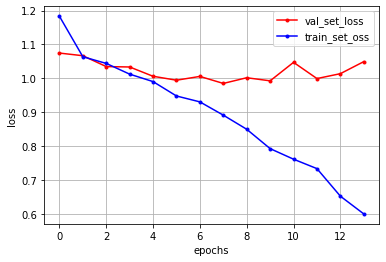

In [8]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [18]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model
caltech_dir = "/Users/jiwon/Desktop/test"
# caltech_dir = "./multi_img_data/imgs_others_test"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)
    
X = np.array(X)


# np.resize(img, (-1, <image shape>)
# model = load_model('./model/multi_img_classification.model')
#model = load_model('/Users/jiwon/model/multi_img_classification.model')
model = load_model('./model/multi_img_classification.model')
# X = X.reshape(X_train.shape[0], 720, 1280, 1)
prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "cat"
    elif pre_ans == 1: pre_ans_str = "dog"
    else : pre_ans_str = "rodent"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.

[0.000 1.000 0.000]
1
해당 /Users/jiwon/Desktop/test/정유미.jpg이미지는 dog으로 추정됩니다.
[0.000 0.000 1.000]
2
해당 /Users/jiwon/Desktop/test/나연.jpeg이미지는 rodent으로 추정됩니다.


In [10]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np
import PIL

np.set_printoptions(linewidth=1000)

def save_model(h5_path, model_path):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(10, activation='softmax', input_shape=[784]))

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['acc'])

    mnist = input_data.read_data_sets('mnist')
    model.fit(mnist.train.images, mnist.train.labels,
              validation_data=[mnist.validation.images, mnist.validation.labels],
              epochs=15, batch_size=128, verbose=0)

    model.save(h5_path)
    converter = tf.lite.TFLiteConverter.from_keras_model_file(h5_path)
    flat_data = converter.convert()

    with open(model_path, 'wb') as f:
        f.write(flat_data)

save_model('./mnist.h5', './mnist.tflite')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
U